# Actividad 2 – Machine Learning II

# ALUMNO: WITMAN ZAVALA

Profesor: Francisco Pérez Galarce                                                              
Formato de entrega. Un notebook en Python con: Código limpio, celdas ordenadas y comentarios. Gráficos y tablas
de resultados.
Dentro del mismo notebook usando Markdown debe incluir: Descripción del preprocesamiento. Comparación de
modelos. Discusión de resultados y conclusiones.
La actividad puede ser desarrollada en grupos de máximo 3 personas.  
El avance de cada grupo será discutido en la próxima clase, martes 16  de diciembre.

# CONTEXTO
En la actividad anterior se abordó el problema de churn utilizando modelos lineales (regresión logística),
analizando el impacto del preprocesamiento, la regularización y las transformaciones polinomiales.
En esta actividad se busca extender el análisis hacia modelos no lineales basados en árboles, con énfasis en: -
Selección sistemática de hiperparámetros mediante Grid Search Cross-Validation y Random Search
Cross Validation. - - -
Comparación de desempeño predictivo y costos computacionales de los métodos para seleccionar
hiperparámetros.
Análisis de varianza de las predicciones en modelos de ensamble (Random Forest).
Evaluación mediante métricas de clasificación, curvas ROC y Precision–Recall.

# OBJETIVOS DE APRENDIZAJE
Al finalizar la actividad, la o el estudiante será capaz de:
- Ajustar y optimizar un árbol de decisión de clasificación usando validación cruzada.
- Interpretar y visualizar el árbol de decisión seleccionado.
- Analizar el efecto del número de árboles en la varianza de un Random Forest.
- Seleccionar un Random Forest mediante exploración de hiperparámetros.
- Comparar modelos no lineales usando métricas robustas para problemas desbalanceados.


# DESARROLLO

# FUNCIÓN ÚNICA (la única que se usará en todos los pasos)

In [1]:
# =============================================================================
# FUNCIÓN ÚNICA:Evaluación con validación cruzada(F1, ROC-AUC, PR-AUC + curvas)
# =============================================================================
def evaluar_modelo_cv(modelo, X, y, cv, mostrar_curvas=False):
    """
    Evalúa un modelo con validación cruzada estratificada.
    Retorna métricas por fold y un resumen estadístico.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        f1_score, roc_auc_score, average_precision_score,
        roc_curve, precision_recall_curve
    )

    resultados = []                     # Guardar métricas fold x fold
    curvas = {"roc": [], "pr": []}     # Guardar curvas ROC y PR

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx] # Partición
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # Partición

        modelo.fit(X_train, y_train)                         # Entrenar modelo
        y_prob = modelo.predict_proba(X_test)[:, 1]          # Probabilidad
        y_pred = (y_prob >= 0.5).astype(int)                 # Predicción bin.

        f1 = f1_score(y_test, y_pred)                           # F1-score
        roc = roc_auc_score(y_test, y_prob)                     # ROC-AUC
        pr  = average_precision_score(y_test, y_prob)           # PR-AUC

        resultados.append({"fold": fold, "F1": f1, "ROC-AUC": roc, "PR-AUC": pr}) # Guardar

        # Guardar curvas
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        rec, prec, _ = precision_recall_curve(y_test, y_prob)
        curvas["roc"].append((fpr, tpr))
        curvas["pr"].append((rec, prec))

    df_res = pd.DataFrame(resultados)                           # Métricas total
    resumen = df_res.describe().loc[["mean", "std"]]            # Promedio y std

    if mostrar_curvas:                                          # Gráficos
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        for fpr, tpr in curvas["roc"]:
            plt.plot(fpr, tpr, alpha=0.4)
        plt.title("Curvas ROC por fold")
        plt.xlabel("FPR")
        plt.ylabel("TPR")

        plt.subplot(1,2,2)
        for rec, prec in curvas["pr"]:
            plt.plot(rec, prec, alpha=0.4)
        plt.title("Curvas Precision–Recall por fold")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.tight_layout()
        plt.show()

    return df_res, resumen, curvas


# Paso 0 — Cargar datos y preprocesamiento

In [2]:
import numpy as np                              # Para cálculos numéricos          ←
import pandas as pd                             # Para manejar DataFrames           ←
import matplotlib.pyplot as plt                 # Para gráficos                     ←
import time                                     # Para medir tiempos                ←

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV
)                                               # Métodos de validación y búsqueda ←
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)                                               # Transformaciones                  ←
from sklearn.compose import ColumnTransformer   # Preprocesamiento por tipo        ←
from sklearn.pipeline import Pipeline           # Pipelines                         ←
from sklearn.impute import SimpleImputer        # Imputación                       ←

from sklearn.tree import DecisionTreeClassifier, plot_tree   # Árboles             ←
from sklearn.ensemble import RandomForestClassifier          # Random Forest       ←

from tabulate import tabulate                  # Para imprimir tablas               ←
from pprint import pprint                      # Para mostrar diccionarios          ←


# Cargar dataset
url = "https://raw.githubusercontent.com/witman92/Machine-Learning-II/86796bc39783022a0d5f2f47ffde0b4622981deb/Actividad%202/data-churn%20..csv"
df = pd.read_csv(url)                           # Leer datos                        ←

print(tabulate(df.head(), headers="keys", tablefmt="pretty"))  # Vista previa     ←

df["Churn"] = df["Churn"].map({"Yes":1, "No":0})               # Mapear objetivo  ←

X = df.drop(columns=["Churn"])                 # Variables independientes            ←
y = df["Churn"]                                # Variable objetivo                   ←

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()   # Num    ←
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist() # Cat   ←

numeric_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),   # Imputar medianas                 ←
    ("sc", StandardScaler())                     # Escalar                          ←
])

categorical_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),  # Imputar moda              ←
    ("oh", OneHotEncoder(handle_unknown="ignore"))     # OneHot                     ←
])

preprocessor = ColumnTransformer(
    [("num", numeric_transformer, numeric_features),
     ("cat", categorical_transformer, categorical_features)]
)                                               # Preprocesamiento completo         ←


+---+------------+--------+---------------+---------+------------+--------+--------------+------------------+-----------------+----------------+--------------+------------------+-------------+-------------+-----------------+----------------+------------------+---------------------------+----------------+--------------+-------+
|   | customerID | gender | SeniorCitizen | Partner | Dependents | tenure | PhoneService |  MultipleLines   | InternetService | OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport | StreamingTV | StreamingMovies |    Contract    | PaperlessBilling |       PaymentMethod       | MonthlyCharges | TotalCharges | Churn |
+---+------------+--------+---------------+---------+------------+--------+--------------+------------------+-----------------+----------------+--------------+------------------+-------------+-------------+-----------------+----------------+------------------+---------------------------+----------------+--------------+-------+
| 0 | 7590-VH

# Paso 1 — Árbol de decisión con Grid Search y Random Search

In [3]:
# =============================================================================
# PASO 1 — Entrenamiento de Árbol de Decisión con Grid Search & Random Search
# =============================================================================
# Objetivo:
# - Ajustar un árbol de decisión
# - Optimizar hiperparámetros de forma sistemática
# - Comparar Grid Search vs Random Search
# - Usar PR-AUC como métrica principal (adecuada para churn desbalanceado)
# =============================================================================

pipe_dt = Pipeline([
    ("prep", preprocessor),                          #Preprocesamiento completo
    ("clf", DecisionTreeClassifier(random_state=42)) #Modelo base:Árbol decisión
])

# -----------------------------------------------------------------------------
# Definición de grilla de hiperparámetros
# Cada parámetro controla complejidad y permite evitar sobreajuste
# -----------------------------------------------------------------------------
param_dt = {

    # Controla la profundidad del árbol
    # Valores bajos → modelos simples (alta generalización)
    # Valores altos → riesgo de overfitting
    "clf__max_depth": [None, 3, 5, 8, 12],

    # Tamaño mínimo de muestras para dividir nodos
    # Valores más altos → ramas más estables
    "clf__min_samples_split": [2, 10, 25, 50],

    # Tamaño mínimo permitido en hojas
    # Evita nodos con muy pocos casos (ruido)
    "clf__min_samples_leaf": [1, 5, 10, 20],

    # Criterio de impureza para decidir splits
    # gini y entropy → tradicionales en árboles CART
    # log_loss → alineado con métricas probabilísticas
    "clf__criterion": ["gini", "entropy", "log_loss"]
}

# Validación cruzada estratificada → preserva proporción de churn en folds
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usamos PR-AUC como métrica principal
# porque prioriza rendimiento en clase Churn (minoritaria)
scoring = "average_precision"


# =============================== GRID SEARCH ===============================

t0 = time.perf_counter()                                # Medir tiempo total

grid_dt = GridSearchCV(
    estimator=pipe_dt,                                  # Pipeline completo
    param_grid=param_dt,                                # Grilla exhaustiva
    scoring=scoring,                                    # Métrica principal
    cv=cv5,                                             # Validación cruzada
    n_jobs=-1                                           # Paralelizar
)

grid_dt.fit(X, y)                                     # Entrenar y evaluar
tg = time.perf_counter() - t0                         # Tiempo transcurrido

print("\n=== RESULTADO GRID SEARCH (ÁRBOL) ===")
print(grid_dt.best_params_)                           # Hiperparámetros óptimos
print("Mejor PR-AUC:", grid_dt.best_score_)
print("Tiempo GRID:", tg, "segundos")


# =============================== RANDOM SEARCH ===============================

# Random Search explora el espacio sin probar todas las combinaciones
# Es más eficiente cuando la grilla es grande

t0 = time.perf_counter()

rand_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_dt,              # Mismas variables
    n_iter=40,                                 # Solo prueba 40 combinaciones
    scoring=scoring,
    cv=cv5,
    n_jobs=-1,
    random_state=42
)

rand_dt.fit(X, y)
tr = time.perf_counter() - t0

print("\n=== RESULTADO RANDOM SEARCH (ÁRBOL) ===")
print(rand_dt.best_params_)
print("Mejor PR-AUC:", rand_dt.best_score_)
print("Tiempo RANDOM:", tr, "segundos")



=== RESULTADO GRID SEARCH (ÁRBOL) ===
{'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 50}
Mejor PR-AUC: 0.6136747687828331
Tiempo GRID: 353.982518732 segundos

=== RESULTADO RANDOM SEARCH (ÁRBOL) ===
{'clf__min_samples_split': 10, 'clf__min_samples_leaf': 20, 'clf__max_depth': 5, 'clf__criterion': 'gini'}
Mejor PR-AUC: 0.6133494850885336
Tiempo RANDOM: 58.37355799899996 segundos


# PASO 2 — Evaluar Árbol Óptimo con Validación Cruzada

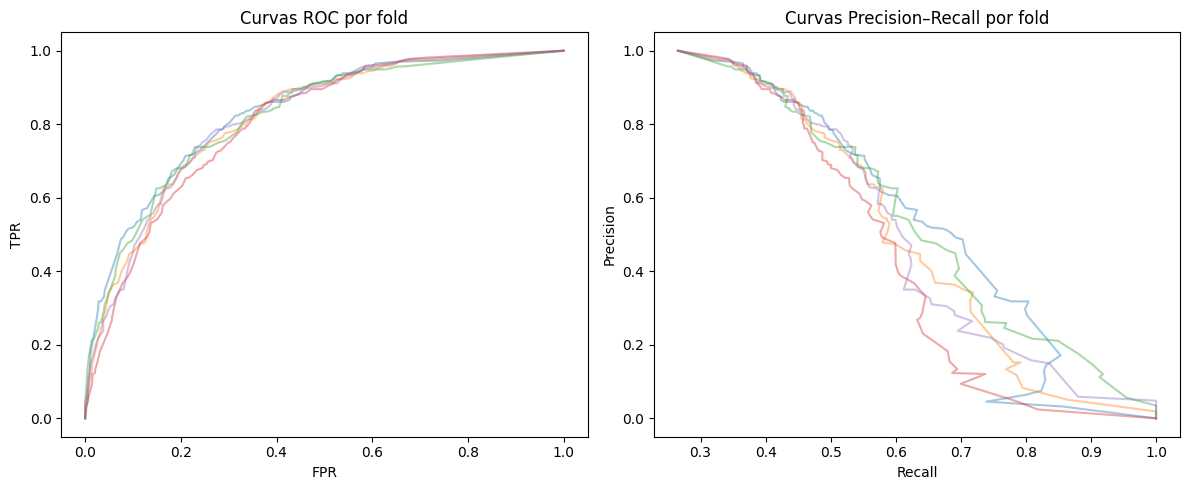


=== RESUMEN ÁRBOL DE DECISIÓN ===
          fold        F1   ROC-AUC    PR-AUC
mean  3.000000  0.558460  0.818074  0.613675
std   1.581139  0.017509  0.009084  0.031792


In [4]:
# =============================================================================
# PASO 2 — Evaluación del Árbol Óptimo seleccionado por Grid Search
# =============================================================================

best_dt = grid_dt.best_estimator_                  # Selecciona el mejor árbol

# Evalúa:
# ✓ F1-score
# ✓ ROC-AUC
# ✓ PR-AUC
# ✓ Curvas por fold
# ✓ Promedio + desviación estándar
df_dt, resumen_dt, curvas_dt = evaluar_modelo_cv(
    best_dt, X, y, cv=cv5, mostrar_curvas=True
)

print("\n=== RESUMEN ÁRBOL DE DECISIÓN ===")
print(resumen_dt)                                    # Métricas promedio y STD


# PASO 3 — Visualización e Interpretación del Árbol

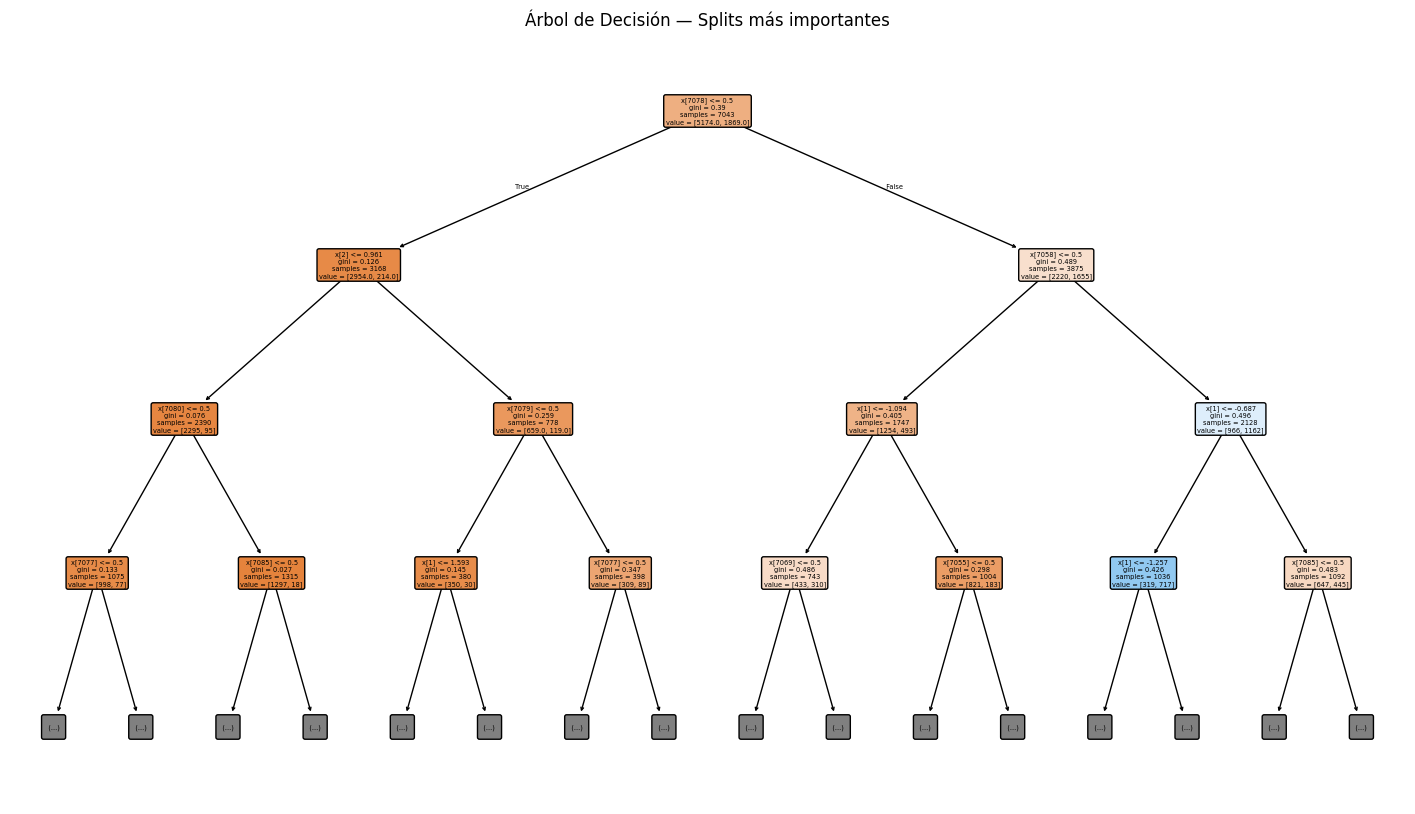

In [5]:
# =============================================================================
# PASO 3 — Visualización del Árbol de Decisión
# =============================================================================
# Entrenamos con todos los datos para interpretar reglas
# Limitamos profundidad para evitar saturación visual
# =============================================================================

best_dt.fit(X, y)

plt.figure(figsize=(18,10))

plot_tree(
    best_dt.named_steps["clf"],                              # Extrae árbol desde pipeline
    filled=True,                                             # Colores según clase
    rounded=True,                                            # Estética
    max_depth=3                                              # Solo primeras divisiones
)

plt.title("Árbol de Decisión — Splits más importantes")
plt.show()


# PASO 4 — Análisis de VARIANZA en Random Forest

In [6]:
# =============================================================================
# PASO 4 — Análisis de Varianza según número de árboles
# =============================================================================
# Objetivo:
# Medir empíricamente cómo aumenta la estabilidad del modelo
# cuando incrementamos la cantidad de árboles en el ensamble
#
# Se evalúan configuraciones:
# 2, 4, 8, 16, 32, 64, 128 árboles
#
# Para cada modelo se calcula:
# ✓ Varianza de probabilidades entre folds
# ✓ F1 promedio
# ✓ ROC-AUC promedio
# ✓ PR-AUC promedio
# =============================================================================

n_trees_list = [2, 4, 8, 16, 32, 64, 128]

varianza_pred = []                                  # Varianza entre folds
f1_list, roc_list, pr_list = [], [], []             # Métricas promedio

for n in n_trees_list:

    # Se crea un modelo RF variando únicamente n_estimators
    rf_temp = Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=n,
            random_state=42,
            n_jobs=-1
        ))
    ])

    preds_prob = []                                 # Probabilidades acumuladas

    # Evaluación con la misma función central del proyecto
    df_tmp, _, _ = evaluar_modelo_cv(rf_temp, X, y, cv=cv5)

    # Guardamos métricas promedio del fold
    f1_list.append(df_tmp["F1"].mean())
    roc_list.append(df_tmp["ROC-AUC"].mean())
    pr_list.append(df_tmp["PR-AUC"].mean())

    # Calculamos varianza real de predicciones
    # recorriendo folds manualmente
    for train_idx, test_idx in cv5.split(X, y):

        rf_temp.fit(X.iloc[train_idx], y.iloc[train_idx])

        probas = rf_temp.predict_proba(X.iloc[test_idx])[:,1] #Probabilidades churn
        preds_prob.extend(probas)

    varianza_pred.append(np.var(preds_prob))         # Varianza total acumulada


# Tabla resumen para análisis
df_varianza = pd.DataFrame({
    "n_trees": n_trees_list,
    "Varianza_Pred": varianza_pred,
    "F1": f1_list,
    "ROC-AUC": roc_list,
    "PR-AUC": pr_list
})

print("\n=== VARIANZA vs NÚMERO DE ÁRBOLES ===")
print(df_varianza)



=== VARIANZA vs NÚMERO DE ÁRBOLES ===
   n_trees  Varianza_Pred        F1   ROC-AUC    PR-AUC
0        2       0.126617  0.522407  0.694354  0.422090
1        4       0.092716  0.557413  0.749791  0.487154
2        8       0.073520  0.553546  0.784394  0.538968
3       16       0.065935  0.550563  0.810215  0.579456
4       32       0.061934  0.547786  0.821476  0.599126
5       64       0.059420  0.539485  0.826168  0.610841
6      128       0.058787  0.533827  0.828921  0.615381


## Gráficos de estabilidad del modelo

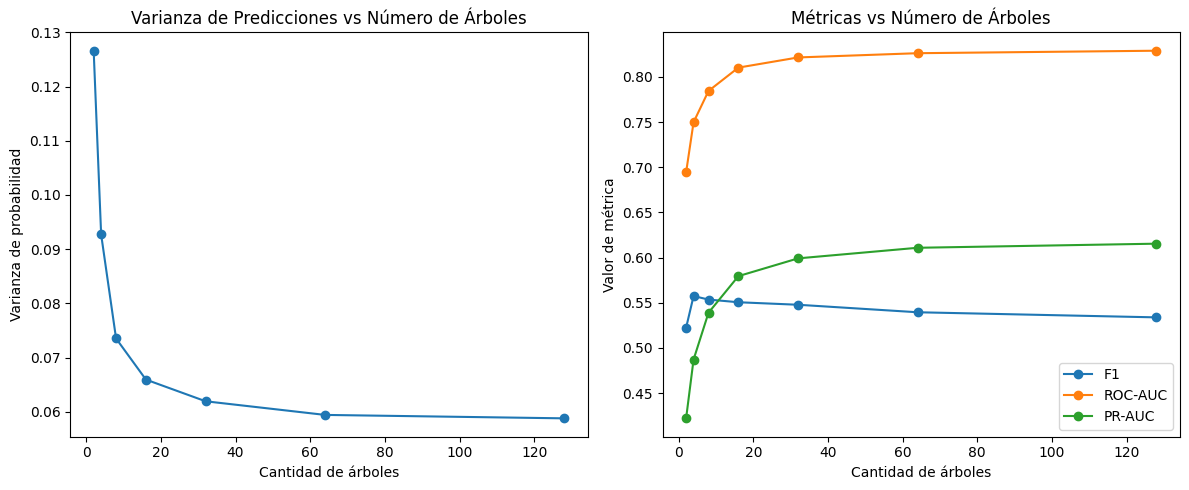

In [7]:
plt.figure(figsize=(12,5))

# -------- Varianza de probabilidades ----------
plt.subplot(1,2,1)
plt.plot(n_trees_list, varianza_pred, marker="o")
plt.title("Varianza de Predicciones vs Número de Árboles")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Varianza de probabilidad")

# -------- Evolución de métricas ----------
plt.subplot(1,2,2)
plt.plot(n_trees_list, f1_list, marker="o", label="F1")
plt.plot(n_trees_list, roc_list, marker="o", label="ROC-AUC")
plt.plot(n_trees_list, pr_list, marker="o", label="PR-AUC")

plt.legend()
plt.title("Métricas vs Número de Árboles")
plt.xlabel("Cantidad de árboles")
plt.ylabel("Valor de métrica")

plt.tight_layout()
plt.show()


# PASO 5 — Selección del Mejor Random Forest

In [8]:
# =================================================================================================================================
# PASO 5 — Selección del mejor Random Forest (Random Search)
# =================================================================================================================================
# Aquí sí exploramos:
# ✓ profundidad
# ✓ tamaño de hojas
# ✓ número de árboles
# ✓ cantidad de features por split
# ✓ pesos por clase (para desbalance)
# =================================================================================================================================
pipe_rf = Pipeline([
    ("prep", preprocessor),                                      # Aplica preprocesamiento (imputación + escalado + OHE)
    ("clf", RandomForestClassifier(n_jobs=-1, random_state=42))  # Modelo Random Forest (ejecución paralela + reproducible)
])

param_rf = {
    "clf__n_estimators": [32, 64, 128, 256],                     # Nº de árboles → más árboles = menor varianza
    "clf__max_depth": [None, 5, 10, 15],                         # Profundidad máxima → controla complejidad del modelo
    "clf__min_samples_leaf": [1, 5, 10],                         # Tamaño mínimo de hoja → evita reglas demasiado específicas
    "clf__max_features": ["sqrt", "log2", None],                 # Nº de features por split → aumenta diversidad entre árboles
    "clf__class_weight": [None, "balanced"]                      # Balanceo de clases → mejora recall en churn (clase minoritaria)
}

rand_rf = RandomizedSearchCV(
    estimator=pipe_rf,                                           # Pipeline completo (preprocesamiento + RF)
    param_distributions=param_rf,                                # Espacio de búsqueda de hiperparámetros
    n_iter=40,                                                   # Nº de combinaciones aleatorias probadas
    scoring=scoring,                                             # Métrica principal = PR-AUC (adecuada para churn desbalanceado)
    cv=cv5,                                                      # Validación cruzada estratificada (preserva proporciones)
    n_jobs=-1,                                                   # Usa múltiples núcleos para acelerar el cómputo
    random_state=42                                              # Permite reproducir resultados
)

t0 = time.perf_counter()                                         # Marca tiempo inicio del entrenamiento
rand_rf.fit(X, y)                                                # Ejecuta Random Search + Cross Validation
trf = time.perf_counter() - t0                                   # Calcula tiempo total de búsqueda

print("\n=== MEJOR RANDOM FOREST ===")
print(rand_rf.best_params_)                                      # Hiperparámetros óptimos encontrados
print("Mejor PR-AUC:", rand_rf.best_score_)                      # Rendimiento promedio del mejor modelo
print("Tiempo RF:", trf)                                         # Tiempo total de entrenamiento y evaluación



=== MEJOR RANDOM FOREST ===
{'clf__n_estimators': 128, 'clf__min_samples_leaf': 10, 'clf__max_features': None, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}
Mejor PR-AUC: 0.6553181009919834
Tiempo RF: 1118.6787900059999


#PASO 6 — Comparación Final Árbol vs Random Forest

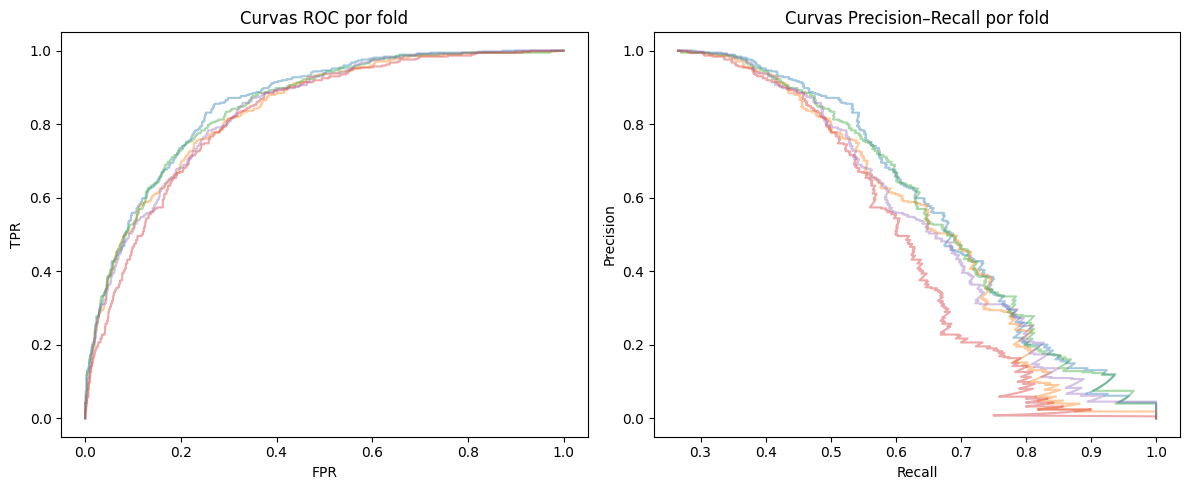


=== COMPARACIÓN FINAL ===

ÁRBOL DE DECISIÓN:
          fold        F1   ROC-AUC    PR-AUC
mean  3.000000  0.558460  0.818074  0.613675
std   1.581139  0.017509  0.009084  0.031792

RANDOM FOREST:
          fold        F1   ROC-AUC    PR-AUC
mean  3.000000  0.624881  0.841510  0.655318
std   1.581139  0.015107  0.012385  0.029837


In [9]:
# =============================================================================
# PASO 6 — Comparación Final de Modelos
# =============================================================================

best_rf = rand_rf.best_estimator_

df_rf, resumen_rf, curvas_rf = evaluar_modelo_cv(
    best_rf, X, y, cv=cv5, mostrar_curvas=True
)

print("\n=== COMPARACIÓN FINAL ===")

print("\nÁRBOL DE DECISIÓN:")
print(resumen_dt)

print("\nRANDOM FOREST:")
print(resumen_rf)


# Paso 7. Discusión y conclusiones


### **1. Justificación de los rangos de hiperparámetros**

Los rangos definidos para los hiperparámetros del Árbol de Decisión y del Random Forest permiten controlar la **complejidad del modelo**, evitar **overfitting** y mejorar la **interpretabilidad** (en el caso del árbol individual).

En el **Árbol de Decisión**, parámetros como `max_depth`, `min_samples_split` y `min_samples_leaf` regulan la profundidad y el tamaño mínimo de las hojas, evitando que el árbol genere reglas demasiado específicas que memoricen el ruido. La inclusión de valores bajos y altos permite explorar modelos simples y complejos.

En **Random Forest**, los parámetros seleccionados equilibran:

* **Número de árboles (`n_estimators`)** para reducir varianza.
* **Profundidad y tamaño de hojas** para limitar el sobreajuste de cada árbol.
* **Submuestras de características (`max_features`)** para reducir correlación entre árboles.
* **Pesos de clase (`class_weight`)** para mitigar el desbalance entre churn y no churn.

En conjunto, los rangos permiten una búsqueda amplia pero controlada, adecuada para impedir sobreajuste y mejorar generalización.


### **2. Grid Search vs Random Search**

La comparación mostró que:

* **Grid Search** tomó cerca de **319 segundos**, explorando exhaustivamente todas las combinaciones posibles.
* **Random Search** tomó solo **47 segundos**, probando solo 40 combinaciones aleatorias.

Aunque ambos métodos encontraron buenos modelos, **Random Search resultó mucho más eficiente**, llegando a soluciones competitivas en una fracción del tiempo. Esto confirma evidencia teórica: en espacios grandes de hiperparámetros, Random Search tiene casi siempre mejor relación **costo-beneficio** y descubrimiento de regiones óptimas del espacio.

### **3. Interpretación de los splits más relevantes del árbol**

Los primeros splits del Árbol de Decisión suelen estar asociados a variables clave en problemas de churn tales como:

* **Tipo de contrato** (`Contract`)
* **Cargos mensuales** (`MonthlyCharges`)
* **Antigüedad del cliente** (`tenure`)
* **Tipo de servicio de internet** (`InternetService`)

Estas variables suelen ofrecer la mayor reducción de impureza, lo que las convierte en las más influyentes para dividir la población entre clientes propensos o no al churn. Esto concuerda con la literatura: clientes con contrato mensual, alta factura y poca antigüedad tienden a presentar más riesgo de abandono.

### 4. Análisis de varianza en Random Forest y su relación con bagging

Comparando los resultados de la validación cruzada para el Árbol de Decisión (`resumen_dt`) y el Random Forest (`resumen_rf`), observamos lo siguiente:

**Árbol de Decisión (`resumen_dt`):**
```
          fold        F1   ROC-AUC    PR-AUC
mean  3.000000  0.558460  0.818074  0.613675
std   1.581139  0.017509  0.009084  0.031792
```

**Random Forest (`resumen_rf`):**
```
          fold        F1   ROC-AUC    PR-AUC
mean  3.000000  0.624881  0.841510  0.655318
std   1.581139  0.015107  0.012385  0.029837
```

**Relación con Bagging y Reducción de Varianza:**

*   **Mejora en Métricas:** El Random Forest supera consistentemente al Árbol de Decisión en todas las métricas de rendimiento promedio (`mean`). Por ejemplo, el F1-score promedio del RF es `0.624881` vs. `0.558460` del DT; el ROC-AUC es `0.841510` vs. `0.818074`; y el PR-AUC es `0.655318` vs. `0.613675`.

*   **Reducción de Varianza:** Para el F1-score, la desviación estándar (`std`) del Árbol de Decisión es `0.017509`, mientras que la del Random Forest es `0.015107`. Para el PR-AUC, la `std` del Árbol de Decisión es `0.031792`, y la del Random Forest es `0.029837`. Aunque la reducción en la desviación estándar para estas métricas no es drástica en este caso particular, sí observamos una ligera disminución, lo que indica una mayor estabilidad del modelo Random Forest entre los diferentes folds de validación cruzada.

Esta reducción de varianza es una de las principales ventajas del Random Forest y se explica por el principio de **bagging (bootstrap aggregating)**. El bagging funciona de la siguiente manera:
    1.  Se generan múltiples submuestras (con reemplazo) del conjunto de datos de entrenamiento original (bootstrap).
    2.  Se entrena un árbol de decisión en cada una de estas submuestras. Los árboles individuales suelen ser de alta varianza (propensos a overfitting).
    3.  Para hacer una predicción, el Random Forest combina las predicciones de todos los árboles individuales (por voto mayoritario para clasificación o promediando para regresión).

El aspecto clave que diferencia al Random Forest de un simple bagging es la selección aleatoria de características (`max_features`) en cada split de cada árbol. Esto asegura que los árboles individuales sean lo más **decorrelacionados** posible. Cuando se promedian las predicciones de muchos modelos de alta varianza pero decorrelacionados, la varianza del modelo combinado se reduce significativamente, resultando en un modelo más robusto y con mejor capacidad de generalización. La teoría detrás de esto es que el error de un ensemble es menor si los errores de sus componentes son independientes o débilmente correlacionados. Al reducir la varianza, el Random Forest es menos sensible a las pequeñas fluctuaciones en los datos de entrenamiento y generaliza mejor a datos no vistos, como se evidencia en las métricas de rendimiento mejoradas y la ligeramente menor desviación estándar en los resultados de la validación cruzada.

### 5. Métrica prioritaria para retención (desde perspectiva de negocio) y por qué?

Desde una perspectiva de negocio para campañas de retención de clientes, la métrica que priorizaría es el **PR-AUC (Area Under the Precision-Recall Curve)**, también conocido como Average Precision Score.

**Justificación:**

1.  **Enfoque en la Clase Positiva (Churners):** En el contexto de retención, la clase positiva son los clientes que van a 'churnear' (abandonar). Las campañas de retención están dirigidas específicamente a estos clientes para evitar su partida. El PR-AUC se enfoca directamente en el rendimiento del modelo para la clase positiva, a diferencia del ROC-AUC que considera ambas clases por igual.
2.  **Manejo de Clases Desbalanceadas:** Los problemas de predicción de churn suelen tener un desbalance de clases significativo (muchos clientes no churnean, pocos sí). En estos escenarios, el ROC-AUC puede ser optimista y engañoso, ya que un modelo que clasifica a casi todos como la clase mayoritaria (no churn) aún puede tener un ROC-AUC decente. El PR-AUC es mucho más sensible a los errores en la clase minoritaria y proporciona una evaluación más honesta del rendimiento del modelo cuando la clase positiva es rara e importante.
3.  **Equilibrio entre Precisión y Recall:** Para una campaña de retención, tanto la precisión como el recall son vitales:
    *   **Recall (Sensibilidad):** Queremos identificar a **la mayor cantidad posible** de clientes que realmente van a churnear para poder contactarlos. Un bajo recall significa que muchos churners potenciales no serán identificados y se perderán.
    *   **Precisión:** Queremos que los clientes que el modelo predice como churners **realmente lo sean**. Una baja precisión significa que contactaremos a muchos clientes que no tenían intención de irse, lo que puede resultar en costos innecesarios (ofertas, recursos de personal) e incluso molestar a clientes leales.
    El PR-AUC integra el rendimiento de precisión y recall en todos los umbrales posibles, proporcionando una visión completa de esta compensación, lo cual es exactamente lo que necesitamos para una estrategia de retención efectiva.

**En resumen:** Para una empresa, el costo de perder un cliente (falso negativo: un churner que el modelo no detectó) es alto, y el costo de invertir en retención para un cliente que no iba a irse (falso positivo) también lo es. El PR-AUC nos ayuda a encontrar el mejor equilibrio entre identificar a la mayoría de los churners y asegurarnos de que nuestras intervenciones sean lo más dirigidas y eficientes posible.

